In [1]:
import os
import sys
import pprint

base_dir = 'F:\Thesis_ssd\MasterThesis3.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Modeling.ResultFitter import ResultFitter
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
import json

helper = HelperFunctions()
%load_ext tensorboard

In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 0.2,
    'seed' : 1,
    'subsample_size' : 0.05
}

loadData = LoadData(**load_args)

full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)
dataGen = DataGenerator(loadData)

Mapping redundancy: [------------------------->              ] 65 %

Mapping redundancy: [----------------------------------->    ] 91 %

In [3]:
hyper_grid = {
        "batch_size" : [16, 32, 64, 128, 256],
        "epochs" : [1],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
model_grid = {
    "start_neurons" : [16, 32, 64, 128, 256, 512, 1024],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 5, 7, 9, 11, 13, 15],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "output_layer_activation" : ["softmax", "sigmoid"]
}


model_nr = 8

use_time_augmentor = True
use_scaler = False
use_noise_augmentor = False
detrend = False
use_minmax = False
use_highpass = False
highpass_freq = 0.1

n_picks = 2

use_tensorboard = False
use_liveplots = True
use_custom_callback = False
use_early_stopping = True
start_from_scratch = True

randomGridSearch = RandomGridSearch(loadData, train_ds, val_ds, test_ds, model_nr, detrend, use_scaler, use_time_augmentor, 
                                    use_noise_augmentor, use_minmax, use_highpass, n_picks, hyper_grid = hyper_grid, 
                                    model_grid = model_grid, use_tensorboard = use_tensorboard,
                                    use_liveplots = use_liveplots, use_custom_callback = use_custom_callback,
                                    use_early_stopping = use_early_stopping, highpass_freq = highpass_freq,
                                    start_from_scratch = start_from_scratch)

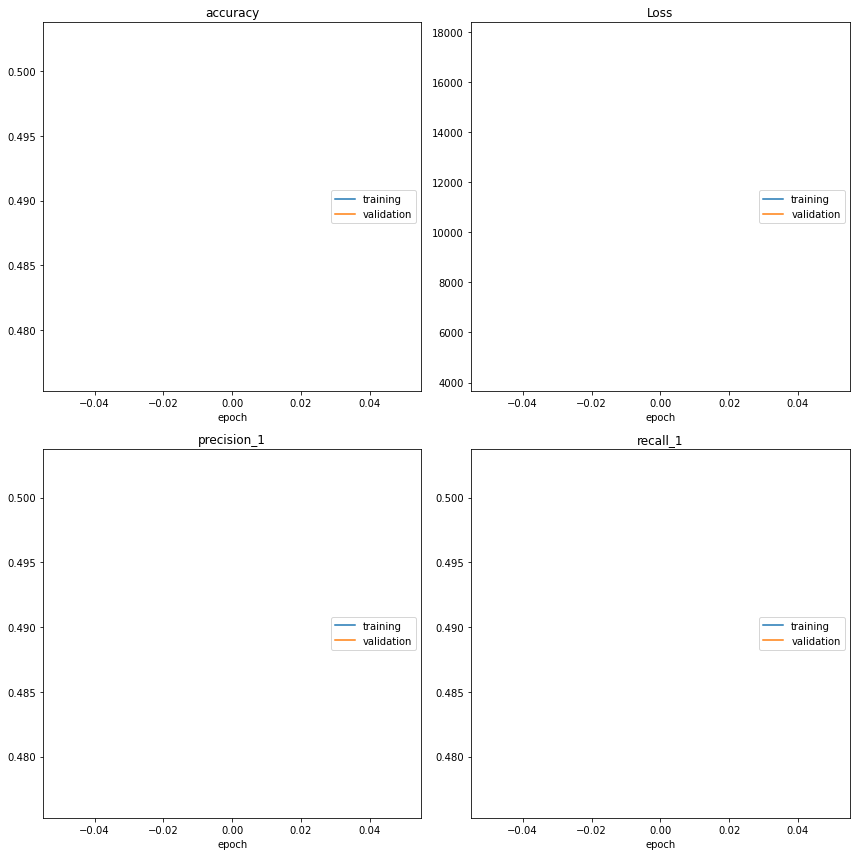

accuracy
	training         	 (min:    0.502, max:    0.502, cur:    0.502)
	validation       	 (min:    0.477, max:    0.477, cur:    0.477)
Loss
	training         	 (min: 17720.859, max: 17720.859, cur: 17720.859)
	validation       	 (min: 4323.890, max: 4323.890, cur: 4323.890)
precision_1
	training         	 (min:    0.502, max:    0.502, cur:    0.502)
	validation       	 (min:    0.477, max:    0.477, cur:    0.477)
recall_1
	training         	 (min:    0.502, max:    0.502, cur:    0.502)
	validation       	 (min:    0.477, max:    0.477, cur:    0.477)
19/19 [==============================] - 18s 963ms/step - loss: 17720.8594 - accuracy: 0.5025 - precision_1: 0.5025 - recall_1: 0.5025 - val_loss: 4323.8896 - val_accuracy: 0.4766 - val_precision_1: 0.4766 - val_recall_1: 0.4766
----------------------------------------------------LOSS----------------------------------------------------------
Min val loss: 1159.541259765625, at index: 0
Min training loss: 1159.545166015625, at inde

In [4]:
results, highest_test_accuracy_index, highest_train_accuracy_index, highest_test_precision_index, highest_test_recall_index= randomGridSearch.fit()

In [5]:
results_df = randomGridSearch.results_df.copy()

In [6]:
results_df[results_df.columns[0:13]]

,batch_size,epochs,learning_rate,optimizer,activation,dropout_rate,filters,kernel_size,l1_r,l2_r,output_layer_activation,padding,start_neurons
0,16,1,0.1,rmsprop,sigmoid,0,17,9,0.01,0.1,softmax,same,64
1,128,1,0.01,sgd,tanh,0.1,17,7,0.1,0.3,softmax,same,1024


In [7]:
results_df[results_df.columns[13:]]

,train_loss,train_accuracy,train_precision,train_recall,val_loss,val_accuracy,val_precision,val_recall
0,1159.545166,0.498387,0.498387,0.498387,1159.541260,0.528846,0.528846,0.528846
1,4323.766113,0.605263,0.605263,0.605263,4323.889648,0.476562,0.476562,0.476562


In [8]:
min_loss, max_accuracy, max_precision, max_recall = randomGridSearch.find_best_performers(results_df)

In [9]:
min_loss_i = min_loss['val_index']
max_acc_i = max_accuracy['val_index']
max_prec_i = max_precision['val_index']
max_recall_i = max_recall['val_index']

In [10]:
min_loss_model = randomGridSearch.fit_from_index(results_df, min_loss_i)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (16, 3, 64)               1552640   
_________________________________________________________________
dropout_6 (Dropout)          (16, 3, 64)               0         
_________________________________________________________________
batch_normalization_6 (Batch (16, 3, 64)               256       
_________________________________________________________________
lstm_5 (LSTM)                (16, 3, 32)               12416     
_________________________________________________________________
dropout_7 (Dropout)          (16, 3, 32)               0         
_________________________________________________________________
batch_normalization_7 (Batch (16, 3, 32)               128       
_________________________________________________________________
dense_4 (Dense)              (16, 3, 16)              

TypeError: generate_gen_args() got multiple values for argument 'use_scaler'

In [ ]:
fit_from_index(results_df, 0)

In [ ]:
build_model_args = self.helper.generate_build_model_args(self.model_nr, batch_size, dropout_rate, 
                                                                     activation, output_layer_activation,
                                                                     l2_r, l1_r, start_neurons, filters, kernel_size, 
                                                                     padding, self.num_classes)

In [ ]:
randomGridSearch.find_best_performers(loaded_result)

In [ ]:
def find_best_performers(results_df):
    train_loss_index = results_df.columns.get_loc('train_loss')
    metrics = results_df[results_df.columns[train_loss_index:]]
    min_loss = {'train_loss' : min(metrics['train_loss']), 'val_loss' : min(metrics['val_loss']), 
                'train_index' : metrics_df[metrics_df['train_loss'] == min(metrics_df['train_loss'])].index[0], 
                'val_index' : metrics_df[metrics_df['val_loss'] == min(metrics_df['val_loss'])].index[0]}
    
    max_accuracy = {'train_accuracy' : max(metrics['train_accuracy']), 'val_accuracy' : max(metrics['val_accuracy']), 
                    'train_index' : metrics_df[metrics_df['train_accuracy'] == max(metrics_df['train_accuracy'])].index[0], 
                    'val_index' : metrics_df[metrics_df['val_accuracy'] == max(metrics_df['val_accuracy'])].index[0]}
    
    max_precision = {'train_precision' : max(metrics['train_precision']), 'val_precision' : max(metrics['val_precision']), 
                     'train_index' : metrics_df[metrics_df['train_precision'] == max(metrics_df['train_precision'])].index[0], 
                     'val_index' : metrics_df[metrics_df['val_precision'] == max(metrics_df['val_precision'])].index[0]}
    
    max_recall = {'train_recall' : max(metrics['train_recall']), 'val_recall' : max(metrics['train_recall']), 
                  'train_index' : metrics_df[metrics_df['train_recall'] == max(metrics_df['train_recall'])].index[0], 
                  'val_index' : metrics_df[metrics_df['val_recall'] == max(metrics_df['val_recall'])].index[0]}
    
    return min_loss, max_accuracy, max_precision, max_recall
    

In [ ]:
find_best_performers(results_df)

In [ ]:
results_df

In [ ]:
print(keys)
print(keys2)

In [ ]:
keys[0]

In [ ]:
import numpy as np
import pandas as pd
hyper_keys = list(hyper_grid.keys())
model_keys = list(model_grid.keys())
metrics_train_keys = ["train_loss", "train_accuracy", "train_presicion", "train_recall"]
metrics_val_keys = ["val_loss", "val_accuracy", "val_presicion", "val_recall"]
header = np.concatenate((hyper_keys, model_keys, metrics_train_keys, metrics_val_keys))
info_table = pd.DataFrame(np.array([i for i in range(len(header))]).reshape(1, 21) ,columns = header)

In [ ]:
info_table

In [ ]:
testing = pd.DataFrame([[0, np.nan]], columns = ["a", "b"])

In [ ]:
to_add = pd.DataFrame(np.array([0 ,1]).reshape(1,2), columns = ["a", "b"])
print(to_add)
testing = testing.append(to_add)
testing

In [ ]:
nan_columns = testing.columns[testing.isnull().any()].tolist()

In [ ]:
temp_df

In [ ]:
nan_columns = temp_df.columns[temp_df.isna().any()].tolist()

In [ ]:
nan_cols = [i for i in temp_df.columns if pd.isnull(temp_df[i].values)]

In [ ]:
for column in temp_df.columns:
    print(temp_df[column].values)

In [ ]:
import pandas as pd

In [ ]:
temp_df['val_loss'].dtype

In [ ]:
dict_list= [{'a' : 1, 'b' : 2}, {'c':3, 'd':4}]
merged_dict = {k:v for x in dict_list for k,v in x.items()}

In [ ]:
merged_dict

In [ ]:
merged_dict_df = pd.DataFrame([merged_dict])

In [ ]:
merged_dict_df

In [ ]:
merged_dict_df.columns[2:]

In [ ]:
import numpy as np
hyper_grid = {
        "batch_size" : [16, 32, 64, 128, 256, 512, 1024],
        "epochs" : [30, 33, 35],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
model_grid = {
    "start_neurons" : [16, 32, 64, 128, 256, 512, 1024],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25, 27],
    "kernel_size" : [3, 5, 7, 9, 11, 13, 15],
    "padding" : ["same"],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "output_layer_activation" : ["softmax", "sigmoid"]
}

def create_results_df(hyper_g, model_g):
    hyper_keys = list(hyper_g.keys())
    model_keys = list(model_g.keys())
    metrics_train_keys = ["train_loss", "train_accuracy", "train_precision", "train_recall"]
    metrics_val_keys = ["val_loss", "val_accuracy", "val_precision", "val_recall"]
    header = np.concatenate((hyper_keys, model_keys, metrics_train_keys, metrics_val_keys))
    results_df = pd.DataFrame(columns = header)
    return results_df
    


def store_params_before_fit(current_picks, results_df, file_name):
    hyper_params = current_picks[1]
    model_params = current_picks[2]
    print(results_df.columns)
    nr_columns = len(results_df.columns)
    nr_picks = len(list(hyper_params.keys())) + len(list(model_params.keys()))
    nr_fillers = nr_columns - nr_picks
    filler_columns = results_df.columns[nr_columns-nr_fillers:]
    filler_dict = {x:np.nan for x in filler_columns}
    params_list = [hyper_params, model_params, filler_dict]
    params_dict = {k:v for x in params_list for k,v in x.items()}
    print(list(params_dict.keys()))
    temp_df = pd.DataFrame.from_dict([params_dict], orient="columns")
    results_df.append(temp_df, ignore_index = True, sort = True)
    return results_df

In [ ]:
current_picks = [{'model_nr': 8, 'index': 0}, {'batch_size': 512, 'epochs': 1, 'learning_rate': 0.001, 'optimizer': 'adam'}, {'activation': 'softmax', 'dropout_rate': 0.5, 'filters': 11, 'kernel_size': 9, 'l1_r': 0.0001, 'l2_r': 0.2, 'output_layer_activation': 'softmax', 'padding': 'same', 'start_neurons': 32}]

In [ ]:
results = create_results_df(hyper_grid, model_grid)

In [ ]:
results_df= store_params_before_fit(current_picks, results, "s")

In [ ]:
results_df

In [ ]:
temp_df